## Sampling Method Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

%matplotlib inline

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. Data

#### 1.1. Load Data

In [3]:
housing = pd.read_csv('housing.csv')

#### 1.2. Review Data

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


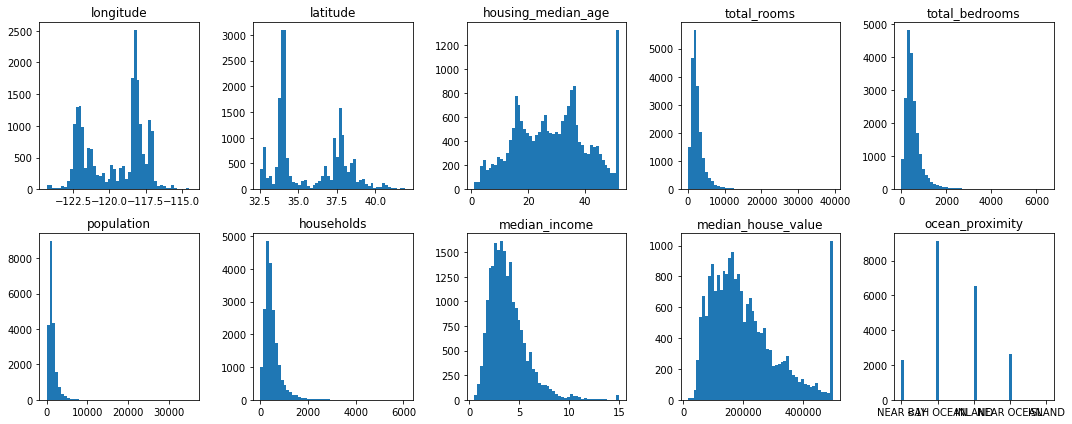

In [3]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15,6))
ax = axes.ravel()

for i, axi in enumerate(ax):
    axi.hist(housing[housing.columns[i]], bins=50)
    axi.set_title(housing.columns[i])

fig.tight_layout()

In [4]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

#### 1.3. Reduce Data

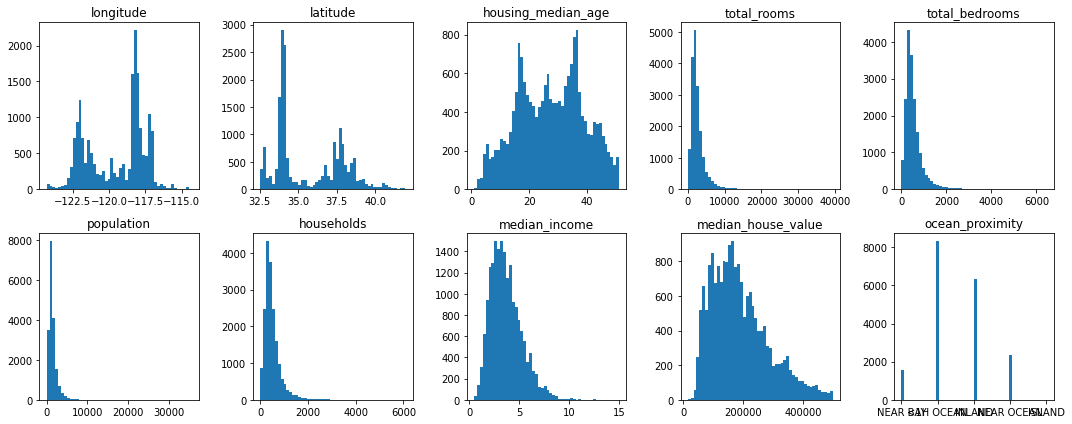

In [5]:
housing_r = housing.copy()
housing_r = housing_r[housing_r["housing_median_age"] < housing_r["housing_median_age"].max()]
housing_r = housing_r[housing_r["median_house_value"] < housing_r["median_house_value"].max()]

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15,6))
ax = axes.ravel()

for i, axi in enumerate(ax):
    axi.hist(housing_r[housing_r.columns[i]], bins=50)
    axi.set_title(housing_r.columns[i])

fig.tight_layout()

In [6]:
housing_r['ocean_proximity'].value_counts()

<1H OCEAN     8331
INLAND        6344
NEAR OCEAN    2328
NEAR BAY      1567
ISLAND           2
Name: ocean_proximity, dtype: int64

In [7]:
housing_r = housing_r.drop(
    housing_r[housing_r["ocean_proximity"] == "ISLAND"].index, axis=0
)
housing_r["ocean_proximity"].value_counts()

<1H OCEAN     8331
INLAND        6344
NEAR OCEAN    2328
NEAR BAY      1567
Name: ocean_proximity, dtype: int64

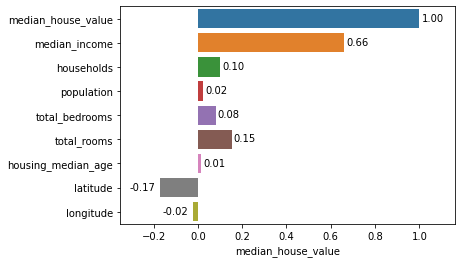

In [8]:
columns = list(housing_r)
columns.reverse()

cor = housing_r[columns].corr()

# sns.heatmap(cor, annot=True)

fig, ax = plt.subplots()
sns.barplot(cor['median_house_value'], cor.index, ax=ax)

xlim_min = np.inf
xlim_max = -np.inf
for patch in ax.patches:
    if patch.get_width() >= 0:
        text_x = patch.get_width()+0.06
    else:
        text_x = patch.get_width()-0.08
        
    if text_x > xlim_max:
        xlim_max = text_x
    if text_x < xlim_min:
        xlim_min = text_x
    text_y = patch.get_y()+0.5
    text = f'{patch.get_width():0.2f}'
    ax.text(text_x, text_y, text, ha='center')
ax.set_xlim(xlim_min-0.1, xlim_max+0.1)
plt.show()

### 2. Sampling

#### 2.1. Data Quantization: 'median_income'

In [9]:
qbins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, np.inf]
qlabels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

housing_r['income_cat'] = pd.cut(
    housing_r['median_income'], 
    bins=qbins, labels=qlabels
)

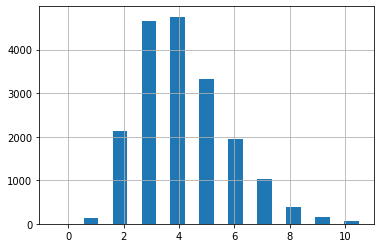

In [10]:
housing_r['income_cat'].hist(bins=np.linspace(-0.5, 10.5, len(qbins)*2));

#### 2.1. Random Sampling

In [11]:
from sklearn.model_selection import train_test_split

train_random, test_random = train_test_split(housing_r, test_size=0.3, random_state=42)

#### 2.2. Stratified Sampling : 'median_income', 'ocean_proximity'

In [12]:
train_strat, test_strat = train_test_split(housing_r, test_size=0.3, random_state=42, stratify=housing_r['income_cat'])

#### 2.3. Sampling Comparison

In [13]:
def income_cat_proportions(housing_r):
    return housing_r["income_cat"].value_counts() / len(housing_r)


compare_props = pd.DataFrame(
    {
        "Random": test_random["income_cat"].value_counts(),
        "Stratified": test_strat["income_cat"].value_counts(),
        "Overall (%)": income_cat_proportions(housing_r) * 100,
        "Random (%)": income_cat_proportions(test_random) * 100,
        "Stratified (%)": income_cat_proportions(test_strat) * 100,
    }
).sort_index()

compare_props["Random %err"] = (
    100 * compare_props["Random (%)"] / compare_props["Overall (%)"] - 100
)
compare_props["Stratified %err"] = (
    100 * compare_props["Stratified (%)"] / compare_props["Overall (%)"] - 100
)

compare_props

,Random,Stratified,Overall (%),Random (%),Stratified (%),Random %err,Stratified %err
1,34,39,0.700054,0.610303,0.700054,-12.820513,-1.421085e-14
2,632,636,11.416263,11.344462,11.416263,-0.628931,0.000000e+00
3,1385,1394,25.018848,24.860887,25.022438,-0.631367,1.434926e-02
4,1437,1427,25.605816,25.794292,25.614791,0.736067,3.505082e-02
5,967,997,17.899838,17.357745,17.896248,-3.028480,-2.005616e-02
6,624,586,10.522348,11.200862,10.518758,6.448311,-3.411805e-02
7,310,308,5.525040,5.564531,5.528630,0.714750,6.497726e-02
8,114,115,2.062466,2.046311,2.064261,-0.783290,8.703220e-02
9,48,48,0.866990,0.861605,0.861605,-0.621118,-6.211180e-01
10,20,21,0.382337,0.359002,0.376952,-6.103286,-1.408451e+00


#### 2.4. Data Restoration : 'median_income'

In [14]:
train_random = train_random.drop("income_cat", axis=1)
test_random = test_random.drop("income_cat", axis=1)
train_strat = train_strat.drop("income_cat", axis=1)
test_strat = test_strat.drop("income_cat", axis=1)
housing_r = housing_r.drop("income_cat", axis=1)

### 3. Pipeline

#### 3.1. pipeline preparation

In [15]:
housing_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18570 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           18570 non-null  float64
 1   latitude            18570 non-null  float64
 2   housing_median_age  18570 non-null  float64
 3   total_rooms         18570 non-null  float64
 4   total_bedrooms      18377 non-null  float64
 5   population          18570 non-null  float64
 6   households          18570 non-null  float64
 7   median_income       18570 non-null  float64
 8   median_house_value  18570 non-null  float64
 9   ocean_proximity     18570 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ycol = ['median_house_value']
catcols = ['ocean_proximity']
numcols = list(set(housing_r.columns) - set(catcols) - set(ycol))
print(f'# numericical columns: {numcols}')
print(f'# categorical columns: {catcols}')

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):  # feature addition
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[
                X, rooms_per_household, population_per_household, bedrooms_per_room
            ]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("attribs_adder", CombinedAttributesAdder()),
                         ("std_scaler", StandardScaler()),])  
cat_pipeline = Pipeline([("onehotencoder", OneHotEncoder(handle_unknown='ignore', drop=None))])
full_pipeline = ColumnTransformer(
    [("num", num_pipeline, numcols), ("cat", cat_pipeline, catcols)]
)

# numericical columns: ['median_income', 'total_rooms', 'longitude', 'population', 'housing_median_age', 'households', 'latitude', 'total_bedrooms']
# categorical columns: ['ocean_proximity']


#### 3.2. Variables Separation

In [17]:
Y_train_random = train_random['median_house_value']
X_train_random = train_random.drop('median_house_value', axis=1)

Y_train_strat = train_strat['median_house_value']
X_train_strat = train_strat.drop('median_house_value', axis=1)

In [18]:
Y_test_random = test_random['median_house_value']
X_test_random = test_random.drop('median_house_value', axis=1)

Y_test_strat = test_strat['median_house_value']
X_test_strat = test_strat.drop('median_house_value', axis=1)

### 4. Machine Learning (overall)

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#### 4.1. preprocessing through pipeline

In [20]:
pipeline_random = deepcopy(full_pipeline)
X_train_random_pre = pipeline_random.fit_transform(X_train_random)

pipeline_strat = deepcopy(full_pipeline)
X_train_strat_pre = pipeline_strat.fit_transform(X_train_strat)

#### 4.2. Random Sampling

In [21]:
rf_random = RandomForestRegressor(n_estimators=30, max_features=8, random_state=42)
rf_random.fit(X_train_random_pre, Y_train_random)

X_test_random_pre = pipeline_random.transform(X_test_random)
Y_pred_random = rf_random.predict(X_test_random_pre)
rmse_random = np.sqrt(mean_squared_error(Y_pred_random, Y_test_random))
print(rmse_random)

44628.384490024335


#### 4.3. Stratified Sampling (overall)

In [22]:
rf_strat = RandomForestRegressor(n_estimators=30, max_features=8, random_state=42)
rf_strat.fit(X_train_strat_pre, Y_train_strat)

X_test_strat_pre = pipeline_strat.transform(X_test_strat)
Y_pred_strat = rf_strat.predict(X_test_strat_pre)
rmse_strat = np.sqrt(mean_squared_error(Y_pred_strat, Y_test_strat))
print(rmse_strat)

44743.58037848807


#### 4.4. Visualization (overall)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


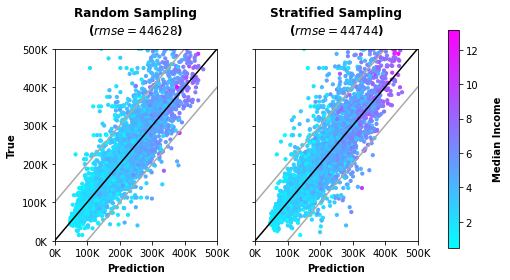

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4), sharex=True, sharey=True)

ax[0].scatter(Y_pred_random, Y_test_random, c=X_test_random['median_income'], cmap='cool', s=10)
im = ax[1].scatter(Y_pred_strat, Y_test_strat, c=X_test_strat['median_income'], cmap='cool', s=10)

ax[0].plot([0,500000], [0,500000], c='k')
ax[1].plot([0,500000], [0,500000], c='k')
ax[0].plot([100000,500000], [0,400000], c='darkgray')
ax[0].plot([0,400000], [100000,500000], c='darkgray')
ax[1].plot([100000,500000], [0,400000], c='darkgray')
ax[1].plot([0,400000], [100000,500000], c='darkgray')

ax[0].set_xlim(0, 500000)
ax[0].set_ylim(0, 500000)

ax[0].set_xlabel('Prediction', fontweight='bold', labelpad=5)
ax[1].set_xlabel('Prediction', fontweight='bold', labelpad=5)
ax[0].set_ylabel('True', fontweight='bold', labelpad=5)

ticks = ax[0].get_xticks()
ticks_K = [f'{tick/1000:0.0f}K' for tick in ticks]
ax[0].set_xticklabels(ticks_K)
ax[0].set_yticklabels(ticks_K)
ax[1].set_xticklabels(ticks_K)

ax[0].set_title(f'Random Sampling\n($rmse={rmse_random:0.0f}$)', fontweight='bold', pad=15)
ax[1].set_title(f'Stratified Sampling\n($rmse={rmse_strat:0.0f}$)', fontweight='bold', pad=15)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Median Income', fontweight='bold', labelpad=15)
fig.tight_layout(rect=(0,0,0.75,1))
fig.savefig('13_comp_10.png', dpi=150)
plt.show()

In [24]:
diff = (rmse_strat/rmse_random - 1) * 100
print(f"RMSE difference is {diff:0.3f} %, relatively.")

RMSE difference is 0.258 %, relatively.


#### 4.5. Visualization (overall, by qbins)

In [25]:
X_test_random.reset_index(drop=True, inplace=True)
X_test_strat.reset_index(drop=True, inplace=True)

In [26]:
Y_pred_random_bin = []
Y_test_random_bin = []
RMSE_random = []
Y_pred_strat_bin = []
Y_test_strat_bin = []
RMSE_strat = []

for qbin in qbins:
    if qbin == qbins[-1]:
        pass
    else:
        qbin_index = X_test_random.loc[X_test_random['median_income'] >= qbin].loc[X_test_random['median_income'] < qbin+1].index
        Y_pred_random_bin.append(Y_pred_random[qbin_index])
        Y_test_random_bin.append(Y_test_random.iloc[qbin_index])
        if len(qbin_index) > 0:
            RMSE_random.append(np.sqrt(mean_squared_error(Y_pred_random_bin[-1], Y_test_random_bin[-1])))
        else:
            RMSE_random.append(np.inf)
        
        qbin_index = X_test_strat.loc[X_test_strat['median_income'] >= qbin].loc[X_test_strat['median_income'] < qbin+1].index
        Y_pred_strat_bin.append(Y_pred_strat[qbin_index])
        Y_test_strat_bin.append(Y_test_strat.iloc[qbin_index])
        if len(qbin_index) > 0:
            RMSE_strat.append(np.sqrt(mean_squared_error(Y_pred_strat_bin[-1], Y_test_strat_bin[-1])))
        else:
            RMSE_strat.append(np.inf)
            

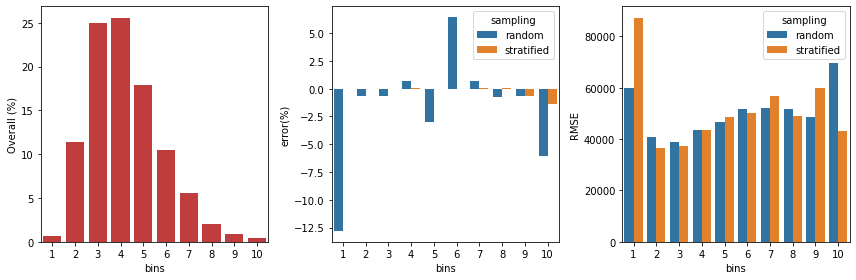

In [27]:
df_RMSE_random = pd.DataFrame({'RMSE': RMSE_random,
                               'sampling': ['random'] * len(RMSE_random),
                               'bin': qlabels
                              })
df_RMSE_strat = pd.DataFrame({'RMSE': RMSE_strat,
                              'sampling': ['stratified'] * len(RMSE_strat),
                              'bin': qlabels
                              })
df_RMSE = pd.concat([df_RMSE_random, df_RMSE_strat], axis=0)

df_sampling_random = pd.DataFrame({'sampling': ['random']*compare_props.shape[0],
                               'error(%)': compare_props["Random %err"],
                               'bin': qlabels
                              })
df_sampling_strat = pd.DataFrame({'sampling': ['stratified']*compare_props.shape[0],
                              'error(%)': compare_props["Stratified %err"],
                              'bin': qlabels
                              })
df_sampling = pd.concat([df_sampling_random, df_sampling_strat], axis=0)

fig, ax = plt.subplots(ncols=3, figsize=(12,4), sharex=True)

sns.barplot(x=compare_props.index, y="Overall (%)", data=compare_props, ax=ax[0], color='C3')
sns.barplot(x="bin", y="error(%)", hue="sampling", data=df_sampling, ax=ax[1])
sns.barplot(x="bin", y="RMSE", hue="sampling", data=df_RMSE, ax=ax[2])

for axi in ax:
    axi.set_xlabel('bins')

fig.tight_layout()
fig.savefig('13_comp_10_bins.png', dpi=150)


### 5. Machine Learning (rich: high median income)

#### 5.1. Data Selection (median income > 8)

In [28]:
test_random_rich = test_random.loc[test_random['median_income'] > 8]
test_strat_rich = test_strat.loc[test_strat['median_income'] > 8]

In [29]:
Y_test_random_rich = test_random_rich['median_house_value']
X_test_random_rich = test_random_rich.drop('median_house_value', axis=1)

Y_test_strat_rich = test_strat_rich['median_house_value']
X_test_strat_rich = test_strat_rich.drop('median_house_value', axis=1)

#### 5.2. Random Sampling

In [30]:
X_test_random_rich_pre = pipeline_random.transform(X_test_random_rich)
Y_pred_random_rich = rf_random.predict(X_test_random_rich_pre)
rmse_random_rich = np.sqrt(mean_squared_error(Y_pred_random_rich, Y_test_random_rich))
print(rmse_random_rich)

51752.43947235599


#### 5.3. Stratified Sampling

In [31]:
X_test_strat_rich_pre = pipeline_strat.transform(X_test_strat_rich)
Y_pred_strat_rich = rf_strat.predict(X_test_strat_rich_pre)
rmse_strat_rich = np.sqrt(mean_squared_error(Y_pred_strat_rich, Y_test_strat_rich))
print(rmse_strat_rich)

61525.525900711305


#### 5.4. Visualization

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


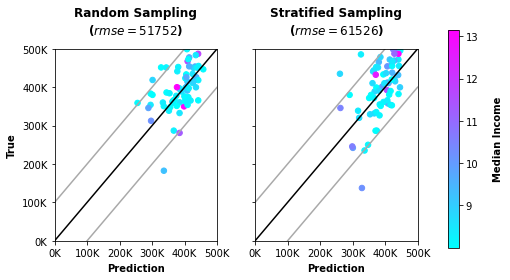

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4), sharex=True, sharey=True)

ax[0].scatter(Y_pred_random_rich, Y_test_random_rich, c=X_test_random_rich['median_income'], cmap='cool', s=30)
im = ax[1].scatter(Y_pred_strat_rich, Y_test_strat_rich, c=X_test_strat_rich['median_income'], cmap='cool', s=30)

ax[0].plot([0,500000], [0,500000], c='k')
ax[1].plot([0,500000], [0,500000], c='k')
ax[0].plot([100000,500000], [0,400000], c='darkgray')
ax[0].plot([0,400000], [100000,500000], c='darkgray')
ax[1].plot([100000,500000], [0,400000], c='darkgray')
ax[1].plot([0,400000], [100000,500000], c='darkgray')

ax[0].set_xlim(0, 500000)
ax[0].set_ylim(0, 500000)

ax[0].set_xlabel('Prediction', fontweight='bold', labelpad=5)
ax[1].set_xlabel('Prediction', fontweight='bold', labelpad=5)
ax[0].set_ylabel('True', fontweight='bold', labelpad=5)

ticks = ax[0].get_xticks()
ticks_K = [f'{tick/1000:0.0f}K' for tick in ticks]
ax[0].set_xticklabels(ticks_K)
ax[0].set_yticklabels(ticks_K)
ax[1].set_xticklabels(ticks_K)

ax[0].set_title(f'Random Sampling\n($rmse={rmse_random_rich:0.0f}$)', fontweight='bold', pad=15)
ax[1].set_title(f'Stratified Sampling\n($rmse={rmse_strat_rich:0.0f}$)', fontweight='bold', pad=15)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Median Income', fontweight='bold', labelpad=15)
fig.tight_layout(rect=(0,0,0.75,1))
fig.savefig('13_comp_rich_10.png')
plt.show()

In [33]:
diff = (rmse_strat_rich/rmse_random_rich - 1) * 100
print(f"RMSE difference is {diff:0.3f} %, relatively.")

RMSE difference is 18.884 %, relatively.


### 6. Statistic Inspection

In [34]:
from functools import reduce

def run_(housing_r, sfeats, rmses_random, rmses_strat, RMSES_random, RMSES_strat, random_state_split):
    
    housing_r['income_cat'] = pd.cut(
        housing_r['median_income'], 
        bins=qbins, labels=qlabels
    )
    train_random, test_random = train_test_split(housing_r, test_size=0.3, random_state=random_state_split)
    train_strat, test_strat = train_test_split(housing_r, test_size=0.3, random_state=random_state_split, stratify=housing_r[sfeats])
    
    train_random = train_random.drop("income_cat", axis=1)
    test_random = test_random.drop("income_cat", axis=1)
    train_strat = train_strat.drop("income_cat", axis=1)
    test_strat = test_strat.drop("income_cat", axis=1)
    housing_r = housing_r.drop("income_cat", axis=1)
    
    Y_train_random = train_random['median_house_value']
    X_train_random = train_random.drop('median_house_value', axis=1)

    Y_train_strat = train_strat['median_house_value']
    X_train_strat = train_strat.drop('median_house_value', axis=1)
    
    Y_test_random = test_random['median_house_value']
    X_test_random = test_random.drop('median_house_value', axis=1)
    X_test_random.reset_index(drop=True, inplace=True)
    
    Y_test_strat = test_strat['median_house_value']
    X_test_strat = test_strat.drop('median_house_value', axis=1)
    X_test_strat.reset_index(drop=True, inplace=True)

    pipeline_random = deepcopy(full_pipeline)
    X_train_random_pre = pipeline_random.fit_transform(X_train_random)

    pipeline_strat = deepcopy(full_pipeline)
    X_train_strat_pre = pipeline_strat.fit_transform(X_train_strat)
    
    rf_random = RandomForestRegressor(n_estimators=30, max_features=8, random_state=42)
    rf_random.fit(X_train_random_pre, Y_train_random)

    X_test_random_pre = pipeline_random.transform(X_test_random)
    Y_pred_random = rf_random.predict(X_test_random_pre)
    rmse_random = np.sqrt(mean_squared_error(Y_pred_random, Y_test_random))
    rmses_random.append(rmse_random)
    
    rf_strat = RandomForestRegressor(n_estimators=30, max_features=8, random_state=42)
    rf_strat.fit(X_train_strat_pre, Y_train_strat)

    X_test_strat_pre = pipeline_strat.transform(X_test_strat)
    Y_pred_strat = rf_strat.predict(X_test_strat_pre)
    rmse_strat = np.sqrt(mean_squared_error(Y_pred_strat, Y_test_strat))
    rmses_strat.append(rmse_strat)

    Y_pred_random_bin = []
    Y_test_random_bin = []
    RMSE_random = []
    Y_pred_strat_bin = []
    Y_test_strat_bin = []
    RMSE_strat = []

    for qbin in qbins:
        if qbin == qbins[-1]:
            pass
        else:
            qbin_index = X_test_random.loc[X_test_random['median_income'] >= qbin].loc[X_test_random['median_income'] < qbin+1].index
            Y_pred_random_bin.append(Y_pred_random[qbin_index])
            Y_test_random_bin.append(Y_test_random.iloc[qbin_index])
            if len(qbin_index) > 0:
                RMSE_random.append(np.sqrt(mean_squared_error(Y_pred_random_bin[-1], Y_test_random_bin[-1])))
            else:
                RMSE_random.append(np.inf)

            qbin_index = X_test_strat.loc[X_test_strat['median_income'] >= qbin].loc[X_test_strat['median_income'] < qbin+1].index
            Y_pred_strat_bin.append(Y_pred_strat[qbin_index])
            Y_test_strat_bin.append(Y_test_strat.iloc[qbin_index])
            if len(qbin_index) > 0:
                RMSE_strat.append(np.sqrt(mean_squared_error(Y_pred_strat_bin[-1], Y_test_strat_bin[-1])))
            else:
                RMSE_strat.append(np.inf)

    RMSES_random.append(RMSE_random)
    RMSES_strat.append(RMSE_strat)

    return rmses_random, rmses_strat, RMSES_random, RMSES_strat
    

def run(housing_r, sfeats):    
    rmses_random = []
    rmses_strat = []
    
    RMSES_random = []
    RMSES_strat = []

    for random_state_split in range(0, 1000, 10):
        rmses_random, rmses_strat, RMSES_random, RMSES_strats = \
        run_(housing_r, sfeats, rmses_random, rmses_strat, RMSES_random, RMSES_strat, random_state_split)
        
#     df_run = pd.DataFrame({'random': rmses_random, 
#                            'strat': rmses_strat, 
#                            'random_rich': rmses_random_rich, 
#                            'strat_rich': rmses_strat_rich}) 
    
#     filename = '100run_' + reduce(lambda x, y:x+'_'+y, sfeats) + '_10.csv'
#     df_run.to_csv(filename)

    return rmses_random, rmses_strat, RMSES_random, RMSES_strat


#### 6.1. Run Over Variables

* 'median_income'

In [35]:
housing_r['income_cat'] = pd.cut(
    housing_r['median_income'], 
    bins=qbins, labels=qlabels
)

tmp = housing_r['income_cat'].value_counts().sort_index()
tmp_index = tmp.index
tmp_value = tmp.values
pd.DataFrame(dict(zip(tmp_index, tmp_value)), index=['counts'])

housing_r.drop('income_cat', axis=1, inplace=True)

In [36]:
run1 = run(housing_r, ['income_cat'])

In [37]:
rmses_random_1 = np.array(run1[0])
rmses_strat_1 = np.array(run1[1])
RMSES_random_1 = np.array(run1[2])
RMSES_strat_1 = np.array(run1[3])

In [38]:
with open('rmses_random_1.csv', 'w') as f:
    for number in rmses_random_1:
        f.write(f"{number}\n")
        
with open('rmses_strat_1.csv', 'w') as f:
    for number in rmses_strat_1:
        f.write(f"{number}\n")        

In [39]:
df_RMSES_random_1 = pd.DataFrame(data=RMSES_random_1, columns=[f'bin{i+1}' for i in range(10)])
df_RMSES_strat_1 = pd.DataFrame(data=RMSES_strat_1, columns=[f'bin{i+1}' for i in range(10)])

df_RMSES_random_1.to_csv('df_RMSES_random_1.csv', index=False)
df_RMSES_strat_1.to_csv('df_RMSES_strat_1.csv', index=False)

* 'median_income' and 'ocean_proximity'

In [40]:
housing_r['income_cat'] = pd.cut(
    housing_r['median_income'], 
    bins=qbins, labels=qlabels
)

In [41]:
tmp = housing_r[['income_cat', 'ocean_proximity']]
tmp_i = housing_r['income_cat'].value_counts().sort_index()

tmp_o_ = tmp[tmp['income_cat']==tmp_i.index[0]]['ocean_proximity'].value_counts()
tmp_o_.name = tmp_i.index[0]
for i in tmp_i.index[1:]:
    tmp_o = tmp[tmp['income_cat']==i]['ocean_proximity'].value_counts()
    tmp_o.name = i
    tmp_o_ = pd.concat([tmp_o_, tmp_o], axis=1)

housing_r.drop('income_cat', axis=1, inplace=True)
tmp_o_

,1,2,3,4,5,6,7,8,9,10
INLAND,55,1122,2016,1617,885,390,161,59,24,15
<1H OCEAN,45,639,1723,2127,1674,1114,622,233,105,49
NEAR BAY,22,123,326,382,309,196,129,55,22,3
NEAR OCEAN,8,236,581,629,456,254,114,36,10,4


In [42]:
run2 = run(housing_r, ['income_cat', 'ocean_proximity'])

In [43]:
rmses_random_2 = np.array(run2[0])
rmses_strat_2 = np.array(run2[1])
RMSES_random_2 = np.array(run2[2])
RMSES_strat_2 = np.array(run2[3])

In [44]:
with open('rmses_random_2.csv', 'w') as f:
    for number in rmses_random_2:
        f.write(f"{number}\n")
        
with open('rmses_strat_2.csv', 'w') as f:
    for number in rmses_strat_2:
        f.write(f"{number}\n")        

In [45]:
df_RMSES_random_2 = pd.DataFrame(data=RMSES_random_2, columns=[f'bin{i+1}' for i in range(10)])
df_RMSES_strat_2 = pd.DataFrame(data=RMSES_strat_2, columns=[f'bin{i+1}' for i in range(10)])

df_RMSES_random_2.to_csv('df_RMSES_random_2.csv', index=False)
df_RMSES_strat_2.to_csv('df_RMSES_strat_2.csv', index=False)

#### 6.2. Visualization

In [46]:
import matplotlib.patches as mpatches

def violin(df1, df2, filename, title):
    fig, ax = plt.subplots(figsize=(10, 5), sharey=True)

    labels = []
    def add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        labels.append((mpatches.Patch(color=color), label))
    
    parts1 = ax.violinplot([df1[col] for col in df1.columns], showextrema=False, positions=qlabels)
    for i, pc in enumerate(parts1['bodies']):
        m = np.mean(pc.get_paths()[0].vertices[:, 0])
        pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], -np.inf, m)
        pc.set_facecolor('b')
        pc.set_edgecolor('b')
    
    ax.errorbar(x=np.array(qlabels)-0.1, y=df1.mean(axis=0), yerr = df1.std(axis=0), 
                fmt='o', mec='b', mew=2, mfc='w', ms=5, lw=2, c='b'
               )
    
    parts2 = ax.violinplot([df2[col] for col in df2.columns], showextrema=False, positions=qlabels)
    for i, pc in enumerate(parts2['bodies']):
        m = np.mean(pc.get_paths()[0].vertices[:, 0])
        pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
        pc.set_facecolor('r')
        pc.set_edgecolor('r')
        
    ax.errorbar(x=np.array(qlabels)+0.1, y=df2.mean(axis=0), yerr = df2.std(axis=0), 
                fmt='o', mec='r', mew=2, mfc='w', ms=5, lw=2, c='r'
               )
    
    ax.set_xticks(qlabels)
    ax.set_xlabel("bins")
    ax.set_ylabel("RMSE")
    ax.set_title(title, pad=10)
    
    add_label(parts1, "random")  
    add_label(parts2, "stratify")  
    ax.legend(*zip(*labels), loc=9)
    fig.tight_layout()
    fig.savefig(filename)

* 'median_income'

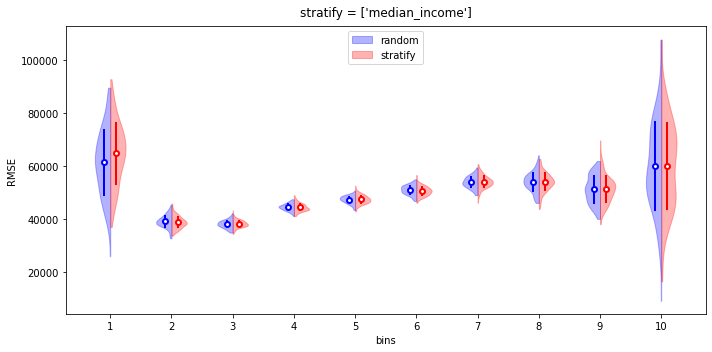

In [47]:
df1 = df_RMSES_random_1
df2 = df_RMSES_strat_1
filename = "RMSES_1.png"
title = "stratify = ['median_income']"

violin(df1, df2, filename, title)

In [48]:
df_RMSES_random_1.describe().loc[['mean', 'std']].to_csv('RMSES_random_1_stats.csv')
df_RMSES_random_1.describe().loc[['mean', 'std']].round(0).astype('int')

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10
mean,61345,39078,38039,44532,47285,50988,53897,53887,51093,60038
std,12664,2435,1517,1314,1476,1815,2261,3693,5357,16933


In [49]:
df_RMSES_strat_1.describe().loc[['mean', 'std']].to_csv('RMSES_strat_1_stats.csv')
df_RMSES_strat_1.describe().loc[['mean', 'std']].round(0).astype('int')

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10
mean,64693,38770,38211,44367,47377,50534,54058,53959,51259,60022
std,11796,2340,1416,1547,1659,1784,2476,3609,5336,16598


* 'median_income' and 'ocean_proximity'

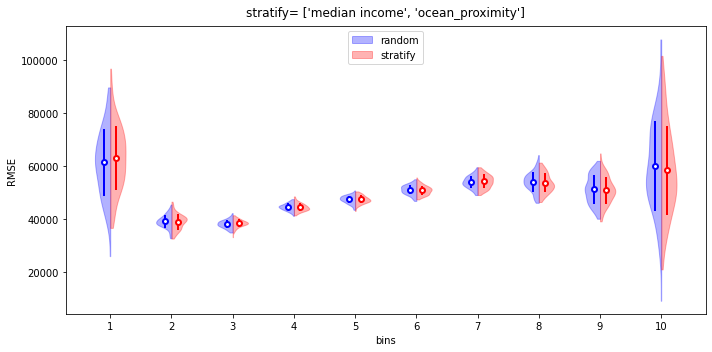

In [50]:
df1 = df_RMSES_random_2
df2 = df_RMSES_strat_2
filename = "RMSES_2.png"
title = "stratify= ['median income', 'ocean_proximity']"

violin(df1, df2, filename, title)

In [51]:
df_RMSES_random_2.describe().loc[['mean', 'std']].to_csv('RMSES_random_2_stats.csv', index=False)
df_RMSES_random_2.describe().loc[['mean', 'std']].round(0).astype('int')

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10
mean,61345,39078,38039,44532,47285,50988,53897,53887,51093,60038
std,12664,2435,1517,1314,1476,1815,2261,3693,5357,16933


In [52]:
df_RMSES_strat_2.describe().loc[['mean', 'std']].to_csv('RMSES_strat_2_stats.csv', index=False)
df_RMSES_strat_2.describe().loc[['mean', 'std']].round(0).astype('int')

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10
mean,62864,38819,38324,44371,47329,50807,54171,53517,50738,58244
std,12117,2916,1456,1465,1464,1731,2547,3589,5062,16894


#### 6.3. Statistical Test

In [53]:
import scipy.stats as stats

In [54]:
def color_test(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'blue' if val < 0.05 else 'red'
    return 'color: %s' % color


def vartest(df1, df2):
    columns = df1.columns
    df_var = pd.DataFrame(columns=columns)

    bartlett = [stats.bartlett(df1[col], df2[col])[1] for col in columns]
    fligner = [stats.fligner(df1[col], df2[col])[1] for col in columns]
    levene = [stats.levene(df1[col], df2[col])[1] for col in columns] 

    df_var.loc['bartlett'] = bartlett
    df_var.loc['fligner'] = fligner
    df_var.loc['levene'] = levene
    
    return df_var

def meantest(df1, df2, equal_var):
    columns = df1.columns
    df_mean = pd.DataFrame(columns=columns)

    ttest = [stats.ttest_ind(df1[col], df2[col], equal_var=equal_var)[1] for col in columns]
 
    df_mean.loc['ttest_ind'] = ttest
    
    return df_mean

* 'median_income'

In [55]:
df_var = vartest(df_RMSES_random_1, df_RMSES_strat_1)
df_var.style.applymap(color_test)

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10
bartlett,0.481220,0.692422,0.494965,0.105554,0.247260,0.864522,0.367840,0.817953,0.968029,0.842607
fligner,0.449511,0.909050,0.329226,0.170933,0.281470,0.644233,0.995228,0.721427,0.499226,0.807156
levene,0.476215,0.833209,0.348558,0.146525,0.279104,0.659279,0.873191,0.537629,0.477493,0.779969


In [56]:
df_mean = meantest(df_RMSES_random_1, df_RMSES_strat_1, True)
df_mean.style.applymap(color_test)

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10
ttest_ind,0.054521,0.363526,0.409027,0.416619,0.680693,0.075655,0.631615,0.889616,0.826707,0.994895


* 'median_income' and 'ocean_proximity'

In [57]:
df_var = vartest(df_RMSES_random_2, df_RMSES_strat_2)
df_var.style.applymap(color_test)

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10
bartlett,0.661063,0.074583,0.685426,0.279835,0.935219,0.635376,0.238417,0.775213,0.573388,0.981772
fligner,0.735450,0.054591,0.285051,0.289711,0.917935,0.505154,0.138364,0.930564,0.372723,0.997156
levene,0.769900,0.058093,0.341636,0.286007,0.973963,0.545828,0.121001,0.986846,0.304100,0.999665


In [58]:
df_mean = meantest(df_RMSES_random_2, df_RMSES_strat_2, True)
df_mean.style.applymap(color_test)

,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10
ttest_ind,0.387060,0.496118,0.176433,0.413052,0.835350,0.469558,0.421741,0.472357,0.630796,0.454183
